# 0. Librerías Base

In [51]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from quantile_forest import RandomForestQuantileRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import joblib
import seaborn as sns

# 1. Importar Dataset
Con base al análisis realizado en la fase EDA de la Data y la implementación del Modelo RF para Feature Selection, se importan la data teniendo en cuenta las siguientes columnas

In [2]:
df = pd.read_csv('../data/dataset_search.csv', usecols=['condition', 'price', 'catalog_listing', 'available_quantity',
                                                        'buying_mode',	'listing_type_id',	'accepts_mercadopago',
                                                        'CATEGORIA_CODE',	'shipping.free_shipping'])

df = df.dropna(subset=['price'])

df.columns

Index(['condition', 'price', 'available_quantity', 'buying_mode',
       'listing_type_id', 'accepts_mercadopago', 'CATEGORIA_CODE',
       'shipping.free_shipping', 'catalog_listing'],
      dtype='object')

# 2. Pipeline de Preprocesamiento y Modelo RFQR
* Codificación de Variables Categóricas y Numéricas dependiendo del tipo
* Entrenamiento del Modelo (RandomForestQuantileRegressor) [Intervlos de Predicción, preds robustas a outliers ]

## 2.1 Transformaciones

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder

# class TargetEncoderWrapper(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.target_encoder = TargetEncoder()

#     def fit(self, X, y):
#         self.target_encoder.fit(X, y)
#         return self

#     def transform(self, X):
#         return self.target_encoder.transform(X)


class BooleanToIntegerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.astype(int)

In [4]:
# [TIPO COLS]
numeric_features = ['available_quantity']
categorical_features = ['condition', 'buying_mode', 'listing_type_id']
categories_feature = ['CATEGORIA_CODE']
boolean_features = ['shipping.free_shipping', 'catalog_listing', 'accepts_mercadopago']

# [DEF TRANSFORMADORES]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

categories_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('target_encoder', TargetEncoder())  
])

boolean_transformer = Pipeline(steps=[
    ('boolean_to_int', BooleanToIntegerTransformer()),  
    ('imputer', SimpleImputer(strategy='most_frequent')) 
])

# [MIX TRANSFORMERS - ColumnTransformer]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  # Para variables numéricas
        ('cat', categorical_transformer, categorical_features),  # Para variables categóricas
        ('category', categories_transformer, categories_feature),  # Para variables de categoría con target encoding
        ('bool', boolean_transformer, boolean_features)  # Para variables booleanas
    ])


## 2.2  Pipeline full con el Modelo


In [8]:
# [PIPELINE PREP + MODEL]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestQuantileRegressor(random_state=42))
])

# [TRAIN/TEST SPLIT]
X = df.drop(['price'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# [HYPERPARAMETER TUNING]
param_grid = {
    'regressor__n_estimators': [100], #trees
    'regressor__max_depth': [10, 30], #depth x tree
    'regressor__min_samples_split': [2, 5] #min_samples_split_node
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error') #minimizar MAE
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# [CROSS-VALIDATION SCORE]
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f'Cross-validation MAE scores: {-scores}')

# [PREDICT]
y_pred = best_model.predict(X_test)

# [PRED Q - TEST DATA]
quantiles = [0.05, 0.5, 0.95]
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
y_pred_quantiles = best_model.named_steps['regressor'].predict(X_test_transformed, quantiles=quantiles)

# [PREDS TO DF FORMAT]
y_pred_quantiles_df = pd.DataFrame(y_pred_quantiles, columns=[f'q{int(q*100)}' for q in quantiles])
print(y_pred_quantiles_df.head())

Cross-validation MAE scores: [419934.82212187 424825.30078481 439987.93561064 430228.54698801
 422694.61493155]
           q5        q50           q95
0   2094.0000   9252.000  2.088700e+04
1  26871.0000  69999.000  1.624999e+06
2  27898.5500  34995.000  7.367514e+04
3  23500.0000  80200.000  1.620000e+06
4   1681.6835   3231.495  1.662767e+04


In [9]:
# *** FLOW WITHOUT GRIDSEARCH ***

# # [FIT]
# pipeline.fit(X_train, y_train)

# # [PREDICT]
# y_pred = pipeline.predict(X_test)

# # [PREP TEST DATA]
# X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# # [PRED Q - TEST DATA]
# quantiles = [0.05, 0.5, 0.95]
# y_pred_quantiles = pipeline.named_steps['regressor'].predict(X_test_transformed, quantiles=quantiles)

# # [PREDS TO DF FORMAT]
# y_pred_quantiles_df = pd.DataFrame(y_pred_quantiles, columns=[f'q{int(q*100)}' for q in quantiles])

# print(y_pred_quantiles_df.head())


## 2.3 Evaluación del Modelo

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predecir en el conjunto de prueba usando el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {round(mse, 1)}')
print(f'Mean Absolute Error (MAE): {round(mae, 1)}')
print(f'R^2 Score: {round(r2, 2)}')

Mean Squared Error (MSE): 11111002014655.5
Mean Absolute Error (MAE): 439616.9
R^2 Score: 0.3


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, color='blue')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()

## 2.4 Guardar el Modelo

In [15]:
# [GUARDAR MODELO]
model_path = "../model/RFQR/best_model.pkl"
joblib.dump(best_model, model_path)

print(f'Se guardó el Modelo en {model_path}')

Se guardó el Modelo en ../model/RFQR/best_model.pkl


## 2.5 Test Predicciones

Estimación de la distribución de posibles valores de l precio

* Q5: el 5% de las observaciones tendrán un valor de predicción igual o menor que este valor.
* Q50: el 50% de las observaciones tendrán un valor de predicción igual o menor que este valor.
* Q95: el 95% de las observaciones tendrán un valor de predicción igual o menor que este valor.

In [18]:
X_test.head(5)

,condition,available_quantity,buying_mode,listing_type_id,accepts_mercadopago,CATEGORIA_CODE,shipping.free_shipping,catalog_listing
811997,new,1,buy_it_now,gold_special,True,MLA409431,False,True
51460,new,1,buy_it_now,gold_special,True,MLA1039,True,True
184127,new,1,buy_it_now,gold_special,True,MLA1168,True,True
445893,new,1,classified,gold_premium,False,MLA1459,False,False
674347,new,1,buy_it_now,gold_special,True,MLA1953,False,True


In [19]:
y_test.head(5)

811997      14579.0
51460     1399999.0
184127      49999.0
445893     101400.0
674347       7754.2
Name: price, dtype: float64

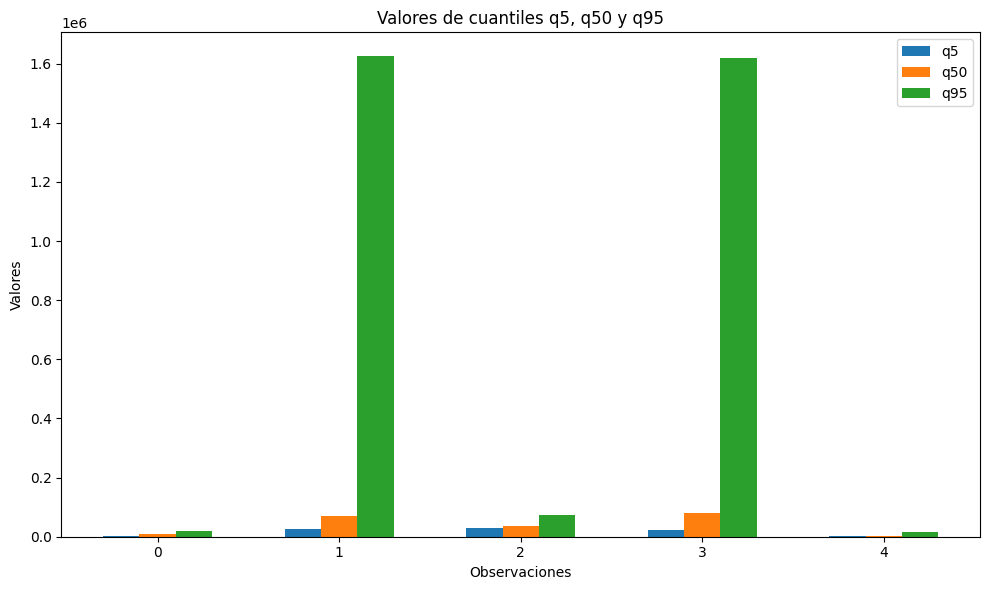

In [20]:
import matplotlib.pyplot as plt

df_quantiles = y_pred_quantiles_df.head(5)

plt.figure(figsize=(10, 6))
plt.bar(df_quantiles.index, df_quantiles['q5'], width=0.2, label='q5')
plt.bar(df_quantiles.index + 0.2, df_quantiles['q50'], width=0.2, label='q50')
plt.bar(df_quantiles.index + 0.4, df_quantiles['q95'], width=0.2, label='q95')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.title('Valores de cuantiles q5, q50 y q95')
plt.xticks(df_quantiles.index + 0.2, df_quantiles.index)
plt.legend()
plt.tight_layout()
plt.show()


## 2.6 Predicciones en Nuevos Datos

In [26]:
new_data = pd.DataFrame({
    'condition': ['new', 'used'],
    'original_price': [100, 200],
    'available_quantity': [10, 5],
    'buying_mode': ['buy_it_now', 'classified'],
    'listing_type_id': ['gold_pro', 'gold_special'],
    'accepts_mercadopago': [True, True],
    'CATEGORIA_CODE': ['MLA1039', 'MLA1168'],
    'shipping.free_shipping': [True, False],
    'catalog_listing': [True, False]
})

# [PREP PIPELINE TO NEW DATA]
# X_new = pipeline.named_steps['preprocessor'].transform(new_data)

In [27]:
quantiles = [0.05, 0.5, 0.95]
y_pred_quantiles_new = best_model.predict(new_data, quantiles=quantiles)

# [Q TO DF]
y_pred_quantiles_df_new = pd.DataFrame(y_pred_quantiles_new, columns=[f'q{int(q*100)}' for q in quantiles])

print(y_pred_quantiles_df_new)


           q5       q50       q95
0  35788.5595  110599.0  860000.0
1   2185.5000    6880.0   75150.0


# 3. Modelo de Clasificación
Debido a que el MarketPlace tiene items muy variados, se propone un modelo de clasificación con base a rangos de Precios. De esta forma, el Modelo será entrenado para determinar con base a features de entrada, el grupo al que pertenece

## 3.1 Preparar Columna de GRUPO-PRECIOS

In [43]:
# [DEFINIR RANGOS DE PRECIOS]

# Cuantiles -> dividir en 10 grupos
quantiles = np.linspace(0, 1, num=11)  # 10 grupos
price_groups = np.quantile(df['price'], quantiles)

# NM_GRUPOS
#labels = [i+1 for i in range(len(price_groups)-1)]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# COLUMN -> NM_GRUPOS
df['price_group'] = pd.cut(df['price'], bins=price_groups, labels=labels, include_lowest=True)

## 3.2 Pipeline Transf y Modelo

In [44]:
# Definir las columnas por tipo
numeric_features = ['available_quantity']
categorical_features = ['condition', 'buying_mode', 'listing_type_id']
categories_feature = ['CATEGORIA_CODE']
boolean_features = ['shipping.free_shipping', 'catalog_listing', 'accepts_mercadopago']

# Definir los transformadores por tipo
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categories_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_encoder', TargetEncoder())
])

boolean_transformer = Pipeline(steps=[
    ('boolean_to_int', BooleanToIntegerTransformer()),  
    ('imputer', SimpleImputer(strategy='most_frequent')) 
])

# Combinar los transformadores con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        #('category', categories_transformer, categories_feature),
        ('bool', boolean_transformer, boolean_features)
    ])

# Definir el pipeline completo con el modelo clasificador (XGBClassifier en este caso)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(labels)))
])

## 3.3 Parameter Tunning y Training

In [45]:
param_grid = {
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7]
}

X = df.drop(['price', 'price_group'], axis=1)
y = df['price_group']

# TRAIN/TEST SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GridSearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

## 3.4 Evluación del Modelo

In [46]:

# Evaluar el mejor modelo en el conjunto de prueba
accuracy = best_model.score(X_test, y_test)
print(f'Accuracy on test set: {accuracy:.2f}')

Accuracy on test set: 0.28


Accuracy on test set: 0.28
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.38      0.29     17666
           1       0.35      0.03      0.06     17722
           2       0.26      0.16      0.20     17757
           3       0.25      0.02      0.03     17607
           4       0.21      0.66      0.32     17792
           5       0.43      0.00      0.01     17894
           6       0.31      0.76      0.44     17860
           7       0.41      0.01      0.02     17725
           8       0.32      0.43      0.37     17857
           9       0.58      0.33      0.42     17711

    accuracy                           0.28    177591
   macro avg       0.33      0.28      0.21    177591
weighted avg       0.33      0.28      0.22    177591



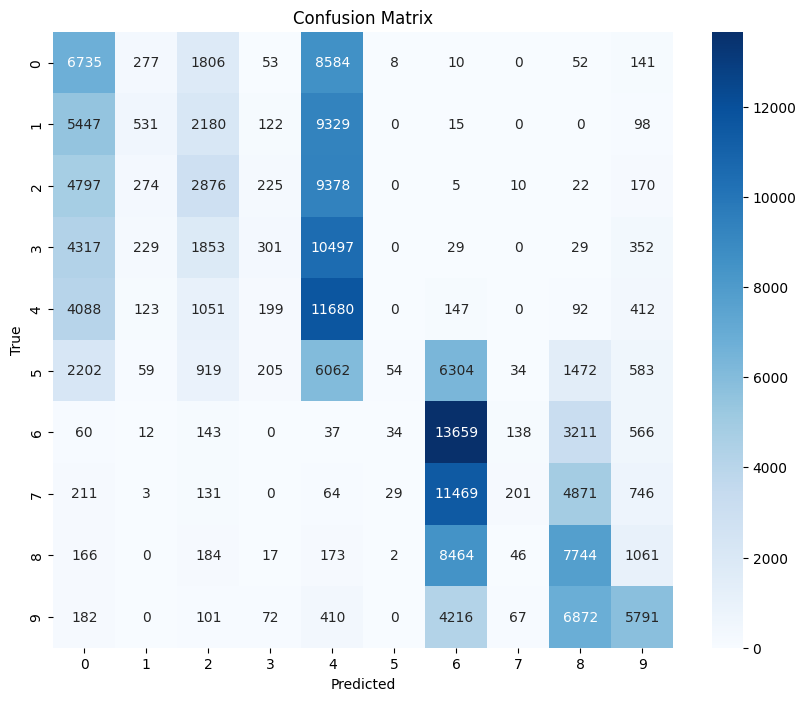

ROC AUC Score: 0.79


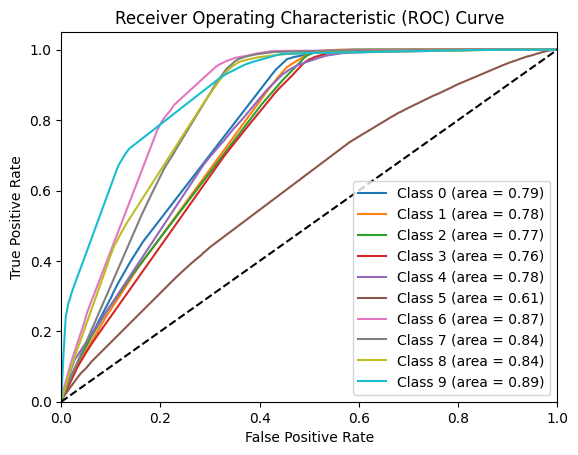

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el mejor modelo en el conjunto de prueba
accuracy = best_model.score(X_test, y_test)
print(f'Accuracy on test set: {accuracy:.2f}')

# Informe de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in labels]))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC score (para cada clase)
y_test_binarized = label_binarize(y_test, classes=labels)
y_pred_proba = best_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Curva ROC
plt.figure()
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

* Buen Rendimiento General:

Un AUC superior a 0.75 para todas las clases indica que el modelo tiene una buena capacidad para distinguir entre los diferentes grupos de precios. Esto sugiere que el modelo es efectivo en identificar correctamente las instancias de cada clase, incluso si la precisión, recall y F1-score para algunas clases individuales son bajos.

* Capacidad de Discriminación:

El modelo es capaz de clasificar correctamente la mayoría de los pares de ejemplos de diferentes clases. Esto es una señal positiva, especialmente en problemas multiclase donde puede ser más difícil obtener altos valores de AUC para todas las clases.

* Posibles Mejores Métricas:

Aunque las métricas como precisión, recall y F1-score pueden ser bajas para algunas clases, un AUC alto sugiere que con ajustes adicionales (por ejemplo, mejor manejo de clases desbalanceadas, ajuste de umbrales de decisión), se puede mejorar el rendimiento del modelo.

**Análisis Adicional**

1. Precision, Recall y F1-Score
* Precision: indica la proporción de verdaderos positivos sobre el total de predicciones positivas (verdaderos positivos + falsos positivos).
* Recall: indica la proporción de verdaderos positivos sobre el total de positivos reales (verdaderos positivos + falsos negativos).
* F1-Score: es la media armónica de la precisión y la exhaustividad, proporcionando un equilibrio entre ambos.

* Clases con Mejor Rendimiento:
*Clase 0:*
Precision: 0.24
Recall: 0.38
F1-Score: 0.29
*Clase 4:*
Precision: 0.21
Recall: 0.66
F1-Score: 0.32
*Clase 6:*
Precision: 0.31
Recall: 0.76
F1-Score: 0.44
*Clase 9:*
Precision: 0.58
Recall: 0.33
F1-Score: 0.42
Estas clases tienen mejores puntuaciones en recall y F1-score, lo que indica que el modelo tiene una capacidad decente para identificar correctamente los ejemplos positivos de estas clases, aunque con una precisión relativamente baja.

* Clases con Peor Rendimiento:
Clase , Clase 3, Clase 5, Clase 7

Estas clases tienen puntuaciones muy bajas en recall y F1-score, indicando que el modelo no está capturando bien los ejemplos de estas clases.

2. Macro y Weighted Average
* Macro Average: calcula las métricas para cada clase y luego toma el promedio (tratando todas las clases por igual).
(-)Precision: 0.33
(-)Recall: 0.28
(-)F1-Score: 0.21

* Weighted Average: considera la cantidad de ejemplos en cada clase, lo que puede dar una mejor indicación del rendimiento general del modelo cuando las clases están desequilibradas.
(-)Precision: 0.33
(-)Recall: 0.28
(-)F1-Score: 0.22

3. Accuracy
Accuracy General: 0.28
La precisión general del modelo es del 28%, lo que indica que el modelo está prediciendo correctamente los grupos de precios solo en el 28% de los casos.

## 3.5 Guardar el Modelo

In [57]:
import joblib

model_path = "../model/XGBClassifier/best_model.pkl"

joblib.dump(best_model, model_path)

print(f'Modelo guardado en {model_path}')

Modelo guardado en ../model/XGBClassifier/best_model.pkl


## 3.6 Predicciones New Data

In [62]:
# Nuevos datos a predecir
new_data = pd.DataFrame({
    'condition': ['new', 'used'],
    'original_price': [100, 200],
    'available_quantity': [10, 5],
    'buying_mode': ['buy_it_now', 'classified'],
    'listing_type_id': ['gold_pro', 'gold_special'],
    'accepts_mercadopago': [True, True],
    'shipping.free_shipping': [True, False],
    'catalog_listing': [True, False]
})

# Predecir con el modelo
predictions = best_model.predict(new_data)

# Imprimir las predicciones
print("Predictions:")
for i, prediction in enumerate(predictions):
    print(f"Data point {i}: Predicted price group - {prediction}")


Predictions:
Data point 0: Predicted price group - 8
Data point 1: Predicted price group - 8


In [66]:
# Función para obtener el rango de precios
def get_price_range(prediction, price_groups):
    if prediction < len(price_groups) - 1:
        return f"{price_groups[prediction]} - {price_groups[prediction + 1]}"
    else:
        return f"Greater than {price_groups[prediction]}"

# Mapear las predicciones a los rangos de precios
predicted_price_ranges = [get_price_range(prediction, price_groups) for prediction in predictions]

# Imprimir los resultados
for i, prediction in enumerate(predictions):
    print(f"Data point {i}: Predicted price group - {prediction} corresponds to price range {predicted_price_ranges[i]}")

Data point 0: Predicted price group - 8 corresponds to price range 69043.0 - 150000.0
Data point 1: Predicted price group - 8 corresponds to price range 69043.0 - 150000.0


# 4. Clustering (Sin terminar)

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd


numeric_features = ['available_quantity']
categorical_features = ['condition', 'buying_mode', 'listing_type_id']
categories_feature = ['CATEGORIA_CODE']
boolean_features = ['shipping.free_shipping', 'catalog_listing', 'accepts_mercadopago']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

categories_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('target_encoder', TargetEncoder())  
])

boolean_transformer = Pipeline(steps=[
    ('boolean_to_int', BooleanToIntegerTransformer()),  
    ('imputer', SimpleImputer(strategy='most_frequent')) 
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  
        ('cat', categorical_transformer, categorical_features),  
        #('category', categories_transformer, categories_feature),  # Para variables de categoría con target encoding
        ('bool', boolean_transformer, boolean_features)  
    ])


kmeans = KMeans(n_clusters=3, random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', kmeans)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['available_quantity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['condition', 'buying_mode',
                                                   'listing_type_id']),
                                                 ('bool',
                                                  Pipeline(steps=[('boolean_to_int',
                                                                   BooleanToIntegerTransformer()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['shipping.free_shipping',
                                                   'catalog_listing',
                                                   'accepts_mercadopago'])])),
                ('clustering', KMeans(n_clusters=3, random_state=42))])

In [41]:

df2 = df.drop(columns=['price', 'price_group'])
pipeline.fit(df2, df['price_group'])

cluster_labels = pipeline.named_steps['clustering'].labels_


In [42]:
x_t = pipeline.transform(df2)
x_t

array([[ 1.28014687, 27.11058691,  1.39766011],
       [ 1.6126359 , 27.38890433,  0.95177647],
       [ 1.07771108, 27.35236882,  0.46777216],
       ...,
       [ 1.30250184, 27.36338145,  1.07639719],
       [ 0.83457237, 27.3575577 ,  1.469228  ],
       [ 1.30250184, 27.36338145,  1.07639719]])

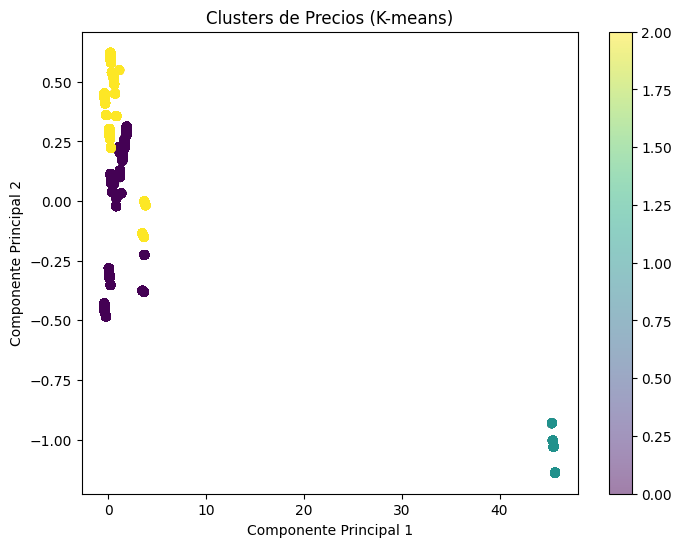

In [43]:
# Reducir la dimensionalidad - vista 2D
pca = PCA(n_components=2)
transformed_data_2d = pca.fit_transform(x_t)

plt.figure(figsize=(8, 6))
plt.scatter(transformed_data_2d[:, 0], transformed_data_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('Clusters de Precios (K-means)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar()
plt.show()
